In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [2]:
train_data = pd.read_csv('data/train_data.csv')
test_data = pd.read_csv('data/test_data.csv')

In [3]:
# Under sampling the false labels as they are propotinally more than true labels
false_labels = train_data[train_data['TenYearCHD'] == 0].sample(1000)
true_labels = train_data[train_data['TenYearCHD'] == 1]
train_data = pd.concat([true_labels, false_labels])

# Data Preprocessing

In [4]:
train_y = train_data["TenYearCHD"].copy()
train_x = train_data.drop("TenYearCHD", axis=1)
test_y = test_data["TenYearCHD"].copy()
test_x = test_data.drop("TenYearCHD", axis=1)

In [5]:
def drop_irrelevant_cols(data):
    
    # 'diabetes', 'BPMeds', 'prevalentStroke' can be dropped as they are highly unbalanced
    cols_to_be_deleted = ['diabetes', 'BPMeds', 'prevalentStroke']
    # 'currentSmoker' should also be dropped as cigsPerDay already encode it's value
    cols_to_be_deleted.append('currentSmoker')
    
    return data.drop(cols_to_be_deleted, axis = 1)

train_x = drop_irrelevant_cols(train_x)
test_x = drop_irrelevant_cols(test_x)

In [6]:
num_attribs = ["age", "sysBP", "diaBP", "glucose", "totChol","cigsPerDay", "BMI", "heartRate"]
cat_attribs = ['prevalentHyp', 'male', 'education']

## Custom Transformer

In [7]:
class FeatureEngineering(BaseEstimator, TransformerMixin):

    def __init__(self, use_age_as_cat_col = False, log_transform_cigsPerDay=False):
        self.use_age_as_cat_col = use_age_as_cat_col
        self.log_transform_cigsPerDay = log_transform_cigsPerDay

    def fit(self, X, y=None):
        return self  # nothing to do as for now

    def transform(self, X, y=None):
        # Use aggregation of sysBP and DiaBP and delete those two columns
        X['avgBP'] = X.apply(lambda x:(x['sysBP'] + x['diaBP'])/2, axis=1)
        X = X.drop(['sysBP', 'diaBP'], axis = 1)

        if self.use_age_as_cat_col:
            age_cat = pd.cut(X["age"],
                               bins=[ 30, 40, 50, 60, np.inf],
                               labels=['30s', '40s', '50s', '60 and above'])
            age_cat = pd.get_dummies(age_cat.astype(str), prefix = 'age')
            X = X.join(age_cat)
            X = X.drop(['age'], axis = 1)

        if self.log_transform_cigsPerDay:
            X['cigsPerDay'] = (X['cigsPerDay']+1).transform(np.log2)

        return np.c_[X]

# FeatureEngineering().fit_transform(train_x[num_attribs])[0]

## Pipeline

In [8]:
num_pipeline = Pipeline([('feature_eng', FeatureEngineering()),
                         ('std_scaler', StandardScaler()),])

cat_pipeline = Pipeline([('one_hot', OneHotEncoder(drop='if_binary')),])

# Can use Pipeline directly to transform but using it in ColumnTransformer
# train_x_transformed = num_pipeline.fit_transform(train_x)

In [9]:
full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", cat_pipeline, cat_attribs),])

In [10]:
train_x_prepared = full_pipeline.fit_transform(train_x)

# Select and Train a Model

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score

log_reg = LogisticRegression()
log_reg.fit(train_x_prepared, train_y)

test_x_prepared = full_pipeline.transform(test_x)
predictions =  log_reg.predict(test_x_prepared)

precision = precision_score(test_y, predictions, pos_label=1)
recall = recall_score(test_y, predictions, pos_label=1)
f1 = f1_score(test_y, predictions)
precision, recall, f1

(0.2702702702702703, 0.26785714285714285, 0.26905829596412556)

In [12]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier()
forest_classifier.fit(train_x_prepared, train_y)

predictions =  forest_classifier.predict(test_x_prepared)

precision = precision_score(test_y, predictions, pos_label=1)
recall = recall_score(test_y, predictions, pos_label=1)
f1 = f1_score(test_y, predictions)
precision, recall, f1

(0.25892857142857145, 0.25892857142857145, 0.25892857142857145)

# Better Evaluation Using Cross-Validation

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_reg, train_x_prepared, train_y, scoring="f1", cv=5)
scores

array([0.42758621, 0.4057971 , 0.40816327, 0.50684932, 0.44604317])

# Fine-Tune Model Using Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}]

forest_classifier = RandomForestClassifier()

grid_search = GridSearchCV(forest_classifier, param_grid, cv=5, scoring='f1',return_train_score=True)
grid_search.fit(train_x_prepared, train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]}],
             return_train_score=True, scoring='f1')

In [15]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [16]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["avgBP"]

cat_encoder = full_pipeline.named_transformers_["cat"].steps[0][1]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
# Categorical Columns were already labelEncoded so need to figure out way to represent them 
sorted(zip(feature_importances, attributes), reverse=True)

[(0.1709647207583345, 'age'),
 (0.15167405306320286, 'BMI'),
 (0.14160050127624968, 'diaBP'),
 (0.13652104236506538, 'sysBP'),
 (0.13410672802545345, 'totChol'),
 (0.10011964201267284, 'cigsPerDay'),
 (0.058875660950631924, 'glucose'),
 (0.02987482652668639, 'heartRate'),
 (0.023583713791598578, 'avgBP'),
 (0.016078024134585495, 0),
 (0.014065683608842486, 1)]

# Evaluation of Classification Models

In [17]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(log_reg, train_x_prepared, train_y, cv=3)

In [43]:
from sklearn.metrics import confusion_matrix
# Each row in a confusion matrix represents an actual class, while each column represents a predicted class.
conf_mx = confusion_matrix(train_y, y_train_pred)
conf_mx

array([[885, 115],
       [287, 158]])

In [41]:
# Perfect Confusion Matrix looks like
confusion_matrix(train_y, train_y)

array([[1000,    0],
       [   0,  445]])

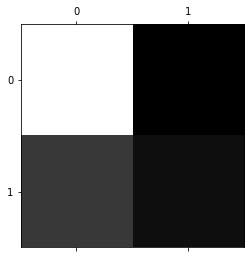

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

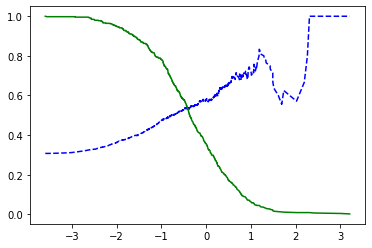

In [26]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(log_reg, train_x_prepared, train_y, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(train_y, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [32]:
threshold_80_precision = thresholds[np.argmax(precisions >= 0.80)] # ~1.3

y_train_pred_80 = (y_scores >= threshold_80_precision)
precision_score(train_y, y_train_pred_80), recall_score(train_y, y_train_pred_80)

(0.8, 0.0449438202247191)